##### Copyright 2019 The TensorFlow Authors.

File is from https://www.tensorflow.org/tutorials/text/text_generation

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Text generation with an RNN

## Setup

### Import TensorFlow and other libraries

In [34]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import pandas as pd
import numpy as np
import os
import time
from nltk import ngrams

checkpoint_dir = 'training-checkpoints/'

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


### Download the dataset

Change the following line to run this code on your own data.

In [4]:
#path_to_file = tf.keras.utils.get_file('speeches.json', 'https://github.com/kfinity/capstone-speeches/raw/master/speeches.json')

### Read the data

First, look in the text:

In [8]:
names = pd.read_csv('names.csv', header=None)
names.columns = ['name','gender','count','year']

In [10]:
unames = names['name'].unique()
# length of text is the number of characters in it
print ('Number of names: {}'.format(len(unames)))

Number of names: 97307


In [11]:
# Take a look at the first 5 names
print(unames[:5])

['Emma' 'Olivia' 'Ava' 'Isabella' 'Sophia']


In [17]:
# The unique characters in the file
vocab = sorted(set(''.join(unames)))
print ('{} unique characters'.format(len(vocab)))

52 unique characters


## Process the text

### Vectorize the text

Before training, we need to map strings to a numerical representation. Create two lookup tables: one mapping characters to numbers, and another for numbers to characters.

In [89]:
tk = Tokenizer(num_words=None, char_level=True, oov_token='UNK')

def get_sequence_of_tokens(corpus):
    ## tokenization
    tk.fit_on_texts(corpus)
    total_words = len(tk.word_index) + 1
    
    ## convert data to sequence of tokens 
    input_sequences = []
    for line in corpus:
        token_list = tk.texts_to_sequences([line])[0]
        for i in range(1, len(token_list)):
            n_gram_sequence = token_list[:i+1]
            input_sequences.append(n_gram_sequence)
    return input_sequences, total_words

vocab = tk.word_index
inp_sequences, total_words = get_sequence_of_tokens(unames)
inp_sequences[:10]


[[3, 14],
 [3, 14, 14],
 [3, 14, 14, 2],
 [11, 7],
 [11, 7, 5],
 [11, 7, 5, 20],
 [11, 7, 5, 20, 5],
 [11, 7, 5, 20, 5, 2],
 [2, 20],
 [2, 20, 2]]

In [247]:
# save tokenizer settings for later
import io
with io.open('tokenizer.json', 'w', encoding='utf-8') as f:
    f.write(json.dumps(tk.to_json(), ensure_ascii=False))

In [250]:
{v: k for k, v in tk.word_index.items()}

{'UNK': 1,
 'a': 2,
 'e': 3,
 'n': 4,
 'i': 5,
 'r': 6,
 'l': 7,
 's': 8,
 'h': 9,
 'y': 10,
 'o': 11,
 't': 12,
 'd': 13,
 'm': 14,
 'k': 15,
 'c': 16,
 'u': 17,
 'j': 18,
 'b': 19,
 'v': 20,
 'z': 21,
 'g': 22,
 'w': 23,
 'p': 24,
 'f': 25,
 'q': 26,
 'x': 27}

In [91]:
print(len(vocab))
print(unames[0])
print(inp_sequences[0:3])

0
Emma
[[3, 14], [3, 14, 14], [3, 14, 14, 2]]


In [93]:
# have to pad sequences to the same length

def generate_padded_sequences(input_sequences):
    max_sequence_len = max([len(x) for x in input_sequences])
    input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))
    
    predictors, label = input_sequences[:,:-1],input_sequences[:,-1]
    label = tf.keras.utils.to_categorical(label, num_classes=total_words)
    return predictors, label, max_sequence_len

predictors, label, max_sequence_len = generate_padded_sequences(inp_sequences)


# max name length
#ml = max([len(w) for w in unames])

#data = pad_sequences(sequences, maxlen=ml, padding='post')
#data = np.array(data)
#data.shape

In [60]:
# series of bigrams
#sbg = pd.DataFrame(data).apply(lambda w: list(ngrams(w,2)), 1)
# convert into dataframe
#bg = pd.DataFrame(list(np.concatenate(sbg.values)), columns=['predictor','label'])
#bg.head()

In [100]:
predictors.shape

(538410, 14)

In [81]:
#predictors = bg['predictor'].to_numpy()
#labels = tf.keras.utils.to_categorical(bg['label'],num_classes=len(vocab)+1)

In [71]:
#num_classes = len(vocab)+1

In [211]:
def create_model(input_len, total_chars):
    
    model = tf.keras.models.Sequential()
    
    # Add Input Embedding Layer
    model.add(tf.keras.layers.Embedding(total_chars, 100, input_length=input_len))
    
    # Add Hidden Layer 1 - LSTM Layer
    model.add(tf.keras.layers.LSTM(200))
    #model.add(tf.keras.layers.Dropout(0.1))
    
    # Add Output Layer
    model.add(tf.keras.layers.Dense(total_chars, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam')
    
    return model

input_len = max_sequence_len - 1
model = create_model(input_len, total_words)
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 14, 100)           2800      
_________________________________________________________________
lstm_3 (LSTM)                (None, 200)               240800    
_________________________________________________________________
dense_3 (Dense)              (None, 28)                5628      
Total params: 249,228
Trainable params: 249,228
Non-trainable params: 0
_________________________________________________________________


In [213]:
history = model.fit(predictors, label, epochs=10)

Epoch 1/10
16826/16826 [==============================] - 52s 3ms/step - loss: 1.7668
Epoch 2/10
16826/16826 [==============================] - 52s 3ms/step - loss: 1.7605
Epoch 3/10
16826/16826 [==============================] - 52s 3ms/step - loss: 1.7555
Epoch 4/10
16826/16826 [==============================] - 52s 3ms/step - loss: 1.7509
Epoch 5/10
16826/16826 [==============================] - 52s 3ms/step - loss: 1.7469
Epoch 6/10
16826/16826 [==============================] - 52s 3ms/step - loss: 1.7434
Epoch 7/10
16826/16826 [==============================] - 52s 3ms/step - loss: 1.7397
Epoch 8/10
16826/16826 [==============================] - 52s 3ms/step - loss: 1.7372
Epoch 9/10
16826/16826 [==============================] - 52s 3ms/step - loss: 1.7338
Epoch 10/10
16826/16826 [==============================] - 52s 3ms/step - loss: 1.7313


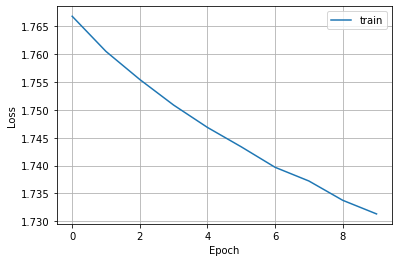

In [214]:
import matplotlib.pyplot as plt
def plot_loss(history):
    plt.plot(history.history['loss'], label='train')
    #plt.plot(history.history['val_loss'], label='validation')
    #plt.ylim([0, 50])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

plot_loss(history)

In [204]:
def generate_text(seed_text, model, randomness=True, temperature=0.25, max_sequence_len=15):
    
    # Low temperatures results in more predictable text.
    # Higher temperatures results in more surprising text.
    # Experiment to find the best setting.
    temperature = temperature
    
    inv_map = {v: k for k, v in tk.word_index.items()}
    
    
    # Here batch size == 1
    model.reset_states()
    predicted_id = 1
    while predicted_id != 0: #for i in range(num_generate):
        input_eval = tk.texts_to_sequences([seed_text])[0]
        input_eval = pad_sequences([input_eval], maxlen=max_sequence_len-1, padding='pre')
        predictions = model(input_eval)
        # remove the batch dimension
        #predictions = tf.squeeze(predictions, 0)

        # using a categorical distribution to predict the character returned by the model
        if randomness:
            predictions = predictions / temperature
            predicted_id = tf.random.categorical(predictions, num_samples=1)[-1,0].numpy()
        else:
            predicted_id = np.argmax(predictions)

        # We pass the predicted character as the next input to the model
        # along with the previous hidden state
        #input_eval = tf.expand_dims([predicted_id], 0)
        if predicted_id == 0:
            break # end of name
        if predicted_id == 1:
            break
        if len(seed_text) > 14:
            break

        seed_text += str(inv_map[predicted_id])

    return seed_text #(start_string + ''.join(text_generated))
    

In [209]:
import random
generate_text('M', model, True, 0.1)

'Maricelseerpura'

In [215]:
model.save('namegen')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: namegen/assets


In [216]:
token_list = tk.texts_to_sequences(['A'])[0]
token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
predicted = model(token_list)
np.argmax(predicted)

4

In [282]:
word2seq = {'UNK': 1,
     'a': 2,
     'e': 3,
     'n': 4,
     'i': 5,
     'r': 6,
     'l': 7,
     's': 8,
     'h': 9,
     'y': 10,
     'o': 11,
     't': 12,
     'd': 13,
     'm': 14,
     'k': 15,
     'c': 16,
     'u': 17,
     'j': 18,
     'b': 19,
     'v': 20,
     'z': 21,
     'g': 22,
     'w': 23,
     'p': 24,
     'f': 25,
     'q': 26,
     'x': 27}
seq2word = {v: k for k, v in word2seq.items()}

ml = discovery.build('ml', 'v1')


def get_names(names):
    temperature = 0.25
    max_len = 15
    randomness = True
    seed_text = names[-1]

    # convert to sequence
    input_eval = [word2seq[c] for c in seed_text.lower()]
    # pad to 14 items
    input_eval = [0] * (max_len-1-len(input_eval)) + input_eval
    
    request_body = { 'instances': [input_eval] }
    request = ml.projects().predict(
        name='projects/sys6016codeathon3/models/namegen/versions/v1',
        body=request_body)

    response = request.execute()
    if 'error' in response:
        # break
        print('error: ' + str(response))
        return names
    
    predictions = np.array(response['predictions'][0]['dense_3'])
    # remove the batch dimension
    #predictions = tf.squeeze(predictions, 0)

    # using a categorical distribution to predict the character returned by the model
    #if randomness:
    #    predictions = predictions / temperature
    #    predicted_id = tf.random.categorical(predictions, num_samples=1)[-1,0].numpy()
    #else:
    predicted_id = np.argmax(predictions)

    # We pass the predicted character as the next input to the model
    # along with the previous hidden state

    if predicted_id > 1 and len(seed_text) < max_len:
        seed_text += str(seq2word[predicted_id])
        names.append(seed_text)
        names = get_names(names)

    return names
    
get_names(['Ann'])

['Ann',
 'Anna',
 'Annal',
 'Annali',
 'Annalis',
 'Annalisa',
 'Annalisab',
 'Annalisabe',
 'Annalisabet',
 'Annalisabeth',
 'Annalisabetha',
 'Annalisabethan',
 'Annalisabethann']

In [278]:
predictions

NameError: name 'predictions' is not defined

In [273]:
word2seq = {'UNK': 1,
     'a': 2,
     'e': 3,
     'n': 4,
     'i': 5,
     'r': 6,
     'l': 7,
     's': 8,
     'h': 9,
     'y': 10,
     'o': 11,
     't': 12,
     'd': 13,
     'm': 14,
     'k': 15,
     'c': 16,
     'u': 17,
     'j': 18,
     'b': 19,
     'v': 20,
     'z': 21,
     'g': 22,
     'w': 23,
     'p': 24,
     'f': 25,
     'q': 26,
     'x': 27}
seq2word = {v: k for k, v in word2seq.items()}
max_len = 15

seq = [word2seq[c] for c in 'helloooo']
seq = [0] * (max_len-1-len(seq)) + seq
seq

[0, 0, 0, 0, 0, 0, 9, 3, 7, 7, 11, 11, 11, 11]

In [267]:
str1 = '000hello'
str2 = ''
for c in str1:
    if c in word2seq.keys():
        str2 += c
str2

'hello'

In [284]:
[s.capitalize() for s in ['hi','hello','yes']]

['Hi', 'Hello', 'Yes']

In [259]:
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="/home/kfinity/keys/sys6016codeathon3-3ca2fa6ec540.json"

from google.api_core.client_options import ClientOptions
from googleapiclient import discovery

#endpoint = 'https://ml.googleapis.com'
#client_options = ClientOptions(api_endpoint=endpoint)
ml = discovery.build('ml', 'v1', client_options=client_options)

# token_list is my variable, output looks like [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2]]
inputs = token_list.tolist() 
request_body = { 'instances': inputs }
request = ml.projects().predict(
    name='projects/sys6016codeathon3/models/namegen/versions/v1',
    body=request_body)

response = request.execute()
print(response['predictions'][0]['dense_3'])

{'predictions': [{'dense_3': [3.1598471061933253e-10, 2.805835841446225e-10, 0.03938860073685646, 0.00758354039862752, 0.18970879912376404, 0.03228096291422844, 0.12639151513576508, 0.17454369366168976, 0.044460222125053406, 0.02167532406747341, 0.023425813764333725, 0.0014150222996249795, 0.018258733674883842, 0.07893252372741699, 0.06286615133285522, 0.019366944208741188, 0.008195511065423489, 0.02831641584634781, 0.005635043140500784, 0.04026518389582634, 0.029881523922085762, 0.025481311604380608, 0.004272173158824444, 0.0016230714973062277, 0.004249899182468653, 0.005117462482303381, 0.003391669364646077, 0.003272879170253873]}]}


In [244]:
service = discovery.build('ml', 'v1')
name = 'projects/sys6016codeathon3/models/namegen'

#if version is not None:
#    name += '/versions/{}'.format(version)

response = service.projects().predict(
    name=name,
    body={'instances': token_list.tolist()}
).execute()

if 'error' in response:
    raise RuntimeError(response['error'])

print(response)

{'predictions': [{'dense_3': [3.1598471061933253e-10, 2.805835841446225e-10, 0.03938860073685646, 0.00758354039862752, 0.18970879912376404, 0.03228096291422844, 0.12639151513576508, 0.17454369366168976, 0.044460222125053406, 0.02167532406747341, 0.023425813764333725, 0.0014150222996249795, 0.018258733674883842, 0.07893252372741699, 0.06286615133285522, 0.019366944208741188, 0.008195511065423489, 0.02831641584634781, 0.005635043140500784, 0.04026518389582634, 0.029881523922085762, 0.025481311604380608, 0.004272173158824444, 0.0016230714973062277, 0.004249899182468653, 0.005117462482303381, 0.003391669364646077, 0.003272879170253873]}]}


In [239]:
print(response['error'])

Prediction failed: Error during model execution: <_MultiThreadedRendezvous of RPC that terminated with:
	status = StatusCode.INVALID_ARGUMENT
	details = "{{function_node __inference__wrapped_model_1601105}} {{function_node __inference__wrapped_model_1601105}} [_Derived_]{{function_node __inference_standard_lstm_1600822_specialized_for_sequential_4_lstm_3_PartitionedCall_at___inference__wrapped_model_1601105}} {{function_node __inference_standard_lstm_1600822_specialized_for_sequential_4_lstm_3_PartitionedCall_at___inference__wrapped_model_1601105}} transpose expects a vector of size 2. But input(1) is a vector of size 3
	 [[{{node transpose}}]]
	 [[sequential_4/lstm_3/PartitionedCall]]
	 [[StatefulPartitionedCall/StatefulPartitionedCall]]"
	debug_error_string = "{"created":"@1605391801.256473380","description":"Error received from peer ipv4:127.0.0.1:8081","file":"src/core/lib/surface/call.cc","file_line":1061,"grpc_message":"{{function_node __inference__wrapped_model_1601105}} {{funct

In [177]:
tf.random.categorical(predicted, num_samples=1)#[-1,0].numpy()

<tf.Tensor: shape=(1, 1), dtype=int64, numpy=array([[17]])>

In [186]:
tf.nn.softmax(predicted/0.1)

<tf.Tensor: shape=(1, 28), dtype=float32, numpy=
array([[0.01366418, 0.01366418, 0.313645  , 0.12118348, 0.01457356,
        0.18714814, 0.02560452, 0.0155455 , 0.01379823, 0.01404277,
        0.02096095, 0.02522721, 0.01396179, 0.01372603, 0.01389207,
        0.01369501, 0.01382707, 0.01439387, 0.01377554, 0.01376426,
        0.01387468, 0.01376271, 0.01371218, 0.0136762 , 0.01383839,
        0.01371272, 0.013665  , 0.01366479]], dtype=float32)>

<AxesSubplot:>

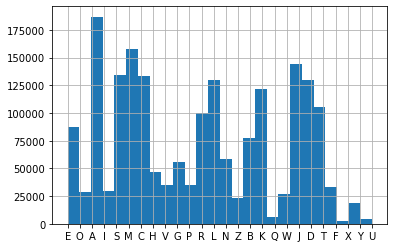

In [197]:
names['name'].str[0].hist(bins=26)

In [198]:
names['name'].str[0].unique()

array(['E', 'O', 'A', 'I', 'S', 'M', 'C', 'H', 'V', 'G', 'P', 'R', 'L',
       'N', 'Z', 'B', 'K', 'Q', 'W', 'J', 'D', 'T', 'F', 'X', 'Y', 'U'],
      dtype=object)

### The prediction task

Given a character, or a sequence of characters, what is the most probable next character? This is the task we're training the model to perform. The input to the model will be a sequence of characters, and we train the model to predict the output—the following character at each time step.

Since RNNs maintain an internal state that depends on the previously seen elements, given all the characters computed until this moment, what is the next character?


### Create training examples and targets

Next divide the text into example sequences. Each input sequence will contain `seq_length` characters from the text.

For each input sequence, the corresponding targets contain the same length of text, except shifted one character to the right.

So break the text into chunks of `seq_length+1`. For example, say `seq_length` is 4 and our text is "Hello". The input sequence would be "Hell", and the target sequence "ello".

To do this first use the `tf.data.Dataset.from_tensor_slices` function to convert the text vector into a stream of character indices.

In [9]:
# The maximum length sentence we want for a single input in characters
seq_length = 100
examples_per_epoch = len(text)//(seq_length+1)

# Create training examples / targets
char_dataset = tf.data.Dataset.from_tensor_slices(text_as_int)

for i in char_dataset.take(5):
  print(idx2char[i.numpy()])

[
M
u
s
i


The `batch` method lets us easily convert these individual characters to sequences of the desired size.

In [10]:
sequences = char_dataset.batch(seq_length+1, drop_remainder=True)

for item in sequences.take(5):
  print(repr(''.join(idx2char[item.numpy()])))

'[Music] [Music] [Music] [Music] [Music] [Applause] unbelievable thank you hello Green Bay thank you i'
"n the great state of Wisconsin home of the legendary Green Bay Packers [Applause] and there's no plac"
"e I'd rather be than right here in America's heartland right and there's no one I'd rather be within "
"you the hard-working Patriots who make our country run so well and it's running right now better mayb"
'e that it ever has thank you the strength of our nation is found in the heart of our people so true t'


For each sequence, duplicate and shift it to form the input and target text by using the `map` method to apply a simple function to each batch:

In [11]:
def split_input_target(chunk):
  input_text = chunk[:-1]
  target_text = chunk[1:]
  return input_text, target_text

dataset = sequences.map(split_input_target)

Print the first examples input and target values:

In [12]:
for input_example, target_example in  dataset.take(1):
  print ('Input data: ', repr(''.join(idx2char[input_example.numpy()])))
  print ('Target data:', repr(''.join(idx2char[target_example.numpy()])))

Input data:  '[Music] [Music] [Music] [Music] [Music] [Applause] unbelievable thank you hello Green Bay thank you '
Target data: 'Music] [Music] [Music] [Music] [Music] [Applause] unbelievable thank you hello Green Bay thank you i'


Each index of these vectors are processed as one time step. For the input at time step 0, the model receives the index for "F" and trys to predict the index for "i" as the next character. At the next timestep, it does the same thing but the `RNN` considers the previous step context in addition to the current input character.

In [13]:
for i, (input_idx, target_idx) in enumerate(zip(input_example[:5], target_example[:5])):
  print("Step {:4d}".format(i))
  print("  input: {} ({:s})".format(input_idx, repr(idx2char[input_idx])))
  print("  expected output: {} ({:s})".format(target_idx, repr(idx2char[target_idx])))

Step    0
  input: 53 ('[')
  expected output: 39 ('M')
Step    1
  input: 39 ('M')
  expected output: 76 ('u')
Step    2
  input: 76 ('u')
  expected output: 74 ('s')
Step    3
  input: 74 ('s')
  expected output: 64 ('i')
Step    4
  input: 64 ('i')
  expected output: 58 ('c')


### Create training batches

We used `tf.data` to split the text into manageable sequences. But before feeding this data into the model, we need to shuffle the data and pack it into batches.

In [14]:
# Batch size
BATCH_SIZE = 64

# Buffer size to shuffle the dataset
# (TF data is designed to work with possibly infinite sequences,
# so it doesn't attempt to shuffle the entire sequence in memory. Instead,
# it maintains a buffer in which it shuffles elements).
BUFFER_SIZE = 10000

dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)

dataset

<BatchDataset shapes: ((64, 100), (64, 100)), types: (tf.int64, tf.int64)>

## Build The Model

Use `tf.keras.Sequential` to define the model. For this simple example three layers are used to define our model:

* `tf.keras.layers.Embedding`: The input layer. A trainable lookup table that will map the numbers of each character to a vector with `embedding_dim` dimensions;
* `tf.keras.layers.GRU`: A type of RNN with size `units=rnn_units` (You can also use a LSTM layer here.)
* `tf.keras.layers.Dense`: The output layer, with `vocab_size` outputs.

In [15]:
# Length of the vocabulary in chars
vocab_size = len(vocab)

# The embedding dimension
embedding_dim = 256

# Number of RNN units
rnn_units = 1024

In [16]:
def build_model(vocab_size, embedding_dim, rnn_units, batch_size):
  model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim,
                              batch_input_shape=[batch_size, None]),
    tf.keras.layers.GRU(rnn_units,
                        return_sequences=True,
                        stateful=True,
                        recurrent_initializer='glorot_uniform'),
    tf.keras.layers.Dense(vocab_size)
  ])
  return model

In [37]:
model = build_model(
    vocab_size = len(vocab),
    embedding_dim=embedding_dim,
    rnn_units=rnn_units,
    batch_size=BATCH_SIZE)

For each character the model looks up the embedding, runs the GRU one timestep with the embedding as input, and applies the dense layer to generate logits predicting the log-likelihood of the next character:

![A drawing of the data passing through the model](images/text_generation_training.png)

Please note that we choose to Keras sequential model here since all the layers in the model only have single input and produce single output. In case you want to retrieve and reuse the states from stateful RNN layer, you might want to build your model with Keras functional API or model subclassing. Please check [Keras RNN guide](https://www.tensorflow.org/guide/keras/rnn#rnn_state_reuse) for more details.

## Try the model

Now run the model to see that it behaves as expected.

First check the shape of the output:

In [38]:
for input_example_batch, target_example_batch in dataset.take(1):
  example_batch_predictions = model(input_example_batch)
  print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")

(64, 100, 88) # (batch_size, sequence_length, vocab_size)


In the above example the sequence length of the input is `100` but the model can be run on inputs of any length:

In [39]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (64, None, 256)           22528     
_________________________________________________________________
gru_3 (GRU)                  (64, None, 1024)          3938304   
_________________________________________________________________
dense_3 (Dense)              (64, None, 88)            90200     
Total params: 4,051,032
Trainable params: 4,051,032
Non-trainable params: 0
_________________________________________________________________


To get actual predictions from the model we need to sample from the output distribution, to get actual character indices. This distribution is defined by the logits over the character vocabulary.

Note: It is important to _sample_ from this distribution as taking the _argmax_ of the distribution can easily get the model stuck in a loop.

Try it for the first example in the batch:

In [40]:
sampled_indices = tf.random.categorical(example_batch_predictions[0], num_samples=1)
sampled_indices = tf.squeeze(sampled_indices,axis=-1).numpy()

This gives us, at each timestep, a prediction of the next character index:

In [41]:
sampled_indices

array([79,  3, 83, 83, 32, 10, 14, 36, 70, 67, 41, 15, 33,  9, 29, 11, 65,
       26, 12, 65, 76, 42,  2, 35, 69, 32, 42, 15, 75, 19, 65, 26, 87, 37,
       38, 84, 82, 62,  6, 13, 56, 69, 48, 29, 71, 70, 44,  5, 76, 69, 87,
       55,  5, 11, 78, 33, 51, 26, 10, 36, 73, 68, 13, 37,  0, 70, 25, 29,
       16,  7, 82, 84, 76, 78, 77,  2,  9, 80, 50, 45,  6, 76, 34, 58, 66,
       38, 76, 27, 18, 19, 42, 49, 78, 56, 70, 36, 26, 60, 66, 27])

Decode these to see the text predicted by this untrained model:

In [42]:
print("Input: \n", repr("".join(idx2char[input_example_batch[0]])))
print()
print("Next Char Predictions: \n", repr("".join(idx2char[sampled_indices ])))

Input: 
 " of evil Tara like al Baghdadi's thank you but you heard the president we are dead last we must do b"

Next Char Predictions: 
 'x$ööF,0JolO1G+C-j?.juP"InFP1t5j?♪KL—çg\'/anVCpoR&un♪_&-wGY?,Jrm/K\no>C2(ç—uwv"+yXS\'uHckLuA45PWwaoJ?ekA'


## Train the model

At this point the problem can be treated as a standard classification problem. Given the previous RNN state, and the input this time step, predict the class of the next character.

### Attach an optimizer, and a loss function

The standard `tf.keras.losses.sparse_categorical_crossentropy` loss function works in this case because it is applied across the last dimension of the predictions.

Because our model returns logits, we need to set the `from_logits` flag.


In [43]:
def loss(labels, logits):
  return tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)

example_batch_loss  = loss(target_example_batch, example_batch_predictions)
print("Prediction shape: ", example_batch_predictions.shape, " # (batch_size, sequence_length, vocab_size)")
print("scalar_loss:      ", example_batch_loss.numpy().mean())

Prediction shape:  (64, 100, 88)  # (batch_size, sequence_length, vocab_size)
scalar_loss:       4.4768476


Configure the training procedure using the `tf.keras.Model.compile` method. We'll use `tf.keras.optimizers.Adam` with default arguments and the loss function.

In [44]:
model.compile(optimizer='adam', loss=loss)

### Configure checkpoints

Use a `tf.keras.callbacks.ModelCheckpoint` to ensure that checkpoints are saved during training:

In [45]:
# Directory where the checkpoints will be saved
checkpoint_dir = '../training_checkpoints'
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

### Execute the training

To keep training time reasonable, use 10 epochs to train the model. In Colab, set the runtime to GPU for faster training.

In [46]:
EPOCHS=10

In [47]:
history = model.fit(dataset, epochs=EPOCHS, callbacks=[checkpoint_callback])

Epoch 1/10
593/593 [==============================] - 26s 44ms/step - loss: 1.8909
Epoch 2/10
593/593 [==============================] - 26s 44ms/step - loss: 1.2408
Epoch 3/10
593/593 [==============================] - 26s 44ms/step - loss: 1.1233
Epoch 4/10
593/593 [==============================] - 26s 45ms/step - loss: 1.0643
Epoch 5/10
593/593 [==============================] - 26s 44ms/step - loss: 1.0242
Epoch 6/10
593/593 [==============================] - 26s 44ms/step - loss: 0.9931
Epoch 7/10
593/593 [==============================] - 26s 45ms/step - loss: 0.9674
Epoch 8/10
593/593 [==============================] - 26s 44ms/step - loss: 0.9463
Epoch 9/10
593/593 [==============================] - 26s 44ms/step - loss: 0.9281
Epoch 10/10
593/593 [==============================] - 26s 44ms/step - loss: 0.9124


## Generate text

### Restore the latest checkpoint

To keep this prediction step simple, use a batch size of 1.

Because of the way the RNN state is passed from timestep to timestep, the model only accepts a fixed batch size once built.

To run the model with a different `batch_size`, we need to rebuild the model and restore the weights from the checkpoint.


In [48]:
tf.train.latest_checkpoint(checkpoint_dir)

'../training_checkpoints/ckpt_10'

In [49]:
model = build_model(vocab_size, embedding_dim, rnn_units, batch_size=1)

model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))

model.build(tf.TensorShape([1, None]))

In [50]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (1, None, 256)            22528     
_________________________________________________________________
gru_4 (GRU)                  (1, None, 1024)           3938304   
_________________________________________________________________
dense_4 (Dense)              (1, None, 88)             90200     
Total params: 4,051,032
Trainable params: 4,051,032
Non-trainable params: 0
_________________________________________________________________


### The prediction loop

The following code block generates the text:

* It Starts by choosing a start string, initializing the RNN state and setting the number of characters to generate.

* Get the prediction distribution of the next character using the start string and the RNN state.

* Then, use a categorical distribution to calculate the index of the predicted character. Use this predicted character as our next input to the model.

* The RNN state returned by the model is fed back into the model so that it now has more context, instead than only one character. After predicting the next character, the modified RNN states are again fed back into the model, which is how it learns as it gets more context from the previously predicted characters.


![To generate text the model's output is fed back to the input](images/text_generation_sampling.png)

Looking at the generated text, you'll see the model knows when to capitalize, make paragraphs and imitates a Shakespeare-like writing vocabulary. With the small number of training epochs, it has not yet learned to form coherent sentences.

In [51]:
def generate_text(model, start_string):
  # Evaluation step (generating text using the learned model)

  # Number of characters to generate
  num_generate = 1000

  # Converting our start string to numbers (vectorizing)
  input_eval = [char2idx[s] for s in start_string]
  input_eval = tf.expand_dims(input_eval, 0)

  # Empty string to store our results
  text_generated = []

  # Low temperatures results in more predictable text.
  # Higher temperatures results in more surprising text.
  # Experiment to find the best setting.
  temperature = 1.0

  # Here batch size == 1
  model.reset_states()
  for i in range(num_generate):
    predictions = model(input_eval)
    # remove the batch dimension
    predictions = tf.squeeze(predictions, 0)

    # using a categorical distribution to predict the character returned by the model
    predictions = predictions / temperature
    predicted_id = tf.random.categorical(predictions, num_samples=1)[-1,0].numpy()

    # We pass the predicted character as the next input to the model
    # along with the previous hidden state
    input_eval = tf.expand_dims([predicted_id], 0)

    text_generated.append(idx2char[predicted_id])

  return (start_string + ''.join(text_generated))

In [59]:
print(generate_text(model, start_string=u"we "))

we have anything else to do with social security trade the space force best office that we're firmp in the last 40 years ago of every city and out here in all flag on the shoulders of American policies have picked about this guy he comes november isk you that's what you can stock the country has never seen and headlines to vote for health their city they were going to be a. Williamerican ancestors saying so much everybody as you know the sir1 i'm not doing what a- the mail is picence of them also it's a trying to come everybody we had law enforcement so get off sypot they're record is building a woman who has been fantastic every day projes she [Applause] and you know when it comes in aders when i took the othey allowed to talk so us it's not that one so many ballots is that buildings all the time [ unlEss with north carolina knows the law enforcements all of them you're not allowed to go on for one in ite nights matter of minnesota in want to get it i called him out hey good eight one

The easiest thing you can do to improve the results it to train it for longer (try `EPOCHS=30`).

You can also experiment with a different start string, or try adding another RNN layer to improve the model's accuracy, or adjusting the temperature parameter to generate more or less random predictions.

In [ ]:
# (Kevin note - stopped here)

## Advanced: Customized Training

The above training procedure is simple, but does not give you much control.

So now that you've seen how to run the model manually let's unpack the training loop, and implement it ourselves. This gives a starting point if, for example, to implement _curriculum learning_ to help stabilize the model's open-loop output.

We will use `tf.GradientTape` to track the gradients. You can learn more about this approach by reading the [eager execution guide](https://www.tensorflow.org/guide/eager).

The procedure works as follows:

* First, reset the RNN state. We do this by calling the `tf.keras.Model.reset_states` method.

* Next, iterate over the dataset (batch by batch) and calculate the *predictions* associated with each.

* Open a `tf.GradientTape`, and calculate the predictions and loss in that context.

* Calculate the gradients of the loss with respect to the model variables using the `tf.GradientTape.grads` method.

* Finally, take a step downwards by using the optimizer's `tf.train.Optimizer.apply_gradients` method.


In [35]:
model = build_model(
    vocab_size = len(vocab),
    embedding_dim=embedding_dim,
    rnn_units=rnn_units,
    batch_size=BATCH_SIZE)

In [36]:
optimizer = tf.keras.optimizers.Adam()

In [37]:
@tf.function
def train_step(inp, target):
  with tf.GradientTape() as tape:
    predictions = model(inp)
    loss = tf.reduce_mean(
        tf.keras.losses.sparse_categorical_crossentropy(
            target, predictions, from_logits=True))
  grads = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(grads, model.trainable_variables))

  return loss

In [38]:
# Training step
EPOCHS = 10

for epoch in range(EPOCHS):
  start = time.time()

  # resetting the hidden state at the start of every epoch
  model.reset_states()

  for (batch_n, (inp, target)) in enumerate(dataset):
    loss = train_step(inp, target)

    if batch_n % 100 == 0:
      template = 'Epoch {} Batch {} Loss {}'
      print(template.format(epoch+1, batch_n, loss))

  # saving (checkpoint) the model every 5 epochs
  if (epoch + 1) % 5 == 0:
    model.save_weights(checkpoint_prefix.format(epoch=epoch))

  print ('Epoch {} Loss {:.4f}'.format(epoch+1, loss))
  print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

model.save_weights(checkpoint_prefix.format(epoch=epoch))

Epoch 1 Batch 0 Loss 4.172773838043213
Epoch 1 Batch 100 Loss 2.319643020629883
Epoch 1 Loss 2.1722
Time taken for 1 epoch 7.495899438858032 sec

Epoch 2 Batch 0 Loss 2.160285711288452
Epoch 2 Batch 100 Loss 1.9182690382003784
Epoch 2 Loss 1.7782
Time taken for 1 epoch 6.883932828903198 sec

Epoch 3 Batch 0 Loss 1.7671966552734375
Epoch 3 Batch 100 Loss 1.6926932334899902
Epoch 3 Loss 1.6017
Time taken for 1 epoch 6.93152117729187 sec

Epoch 4 Batch 0 Loss 1.5692694187164307
Epoch 4 Batch 100 Loss 1.5481702089309692
Epoch 4 Loss 1.4760
Time taken for 1 epoch 7.1686460971832275 sec

Epoch 5 Batch 0 Loss 1.451960802078247
Epoch 5 Batch 100 Loss 1.4631893634796143
Epoch 5 Loss 1.4470
Time taken for 1 epoch 7.46896505355835 sec

Epoch 6 Batch 0 Loss 1.387464165687561
Epoch 6 Batch 100 Loss 1.4172255992889404
Epoch 6 Loss 1.3579
Time taken for 1 epoch 7.1809070110321045 sec

Epoch 7 Batch 0 Loss 1.344409465789795
Epoch 7 Batch 100 Loss 1.3334676027297974
Epoch 7 Loss 1.3486
Time taken for 1